40461


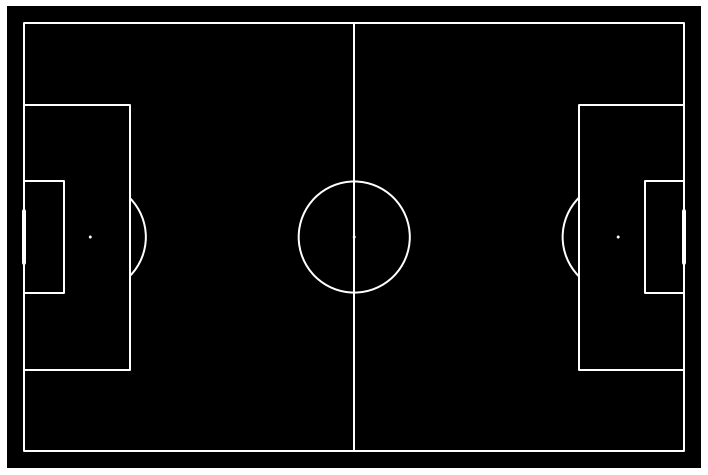

In [30]:
import numpy as np 
import pandas as pd
import json
from mplsoccer.pitch import Pitch, VerticalPitch


path = "C:/Users/brand/desktop/events/events_England.json" 

with open(path) as f:
    data = json.load(f)

train = pd.DataFrame(data)


path2 = "C:/Users/brand/desktop/players.json" 


with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)

lst = ['events_France.json','events_Germany.json','events_Italy.json','events_Spain.json']
pathway = "C:/Users/brand/desktop/events/"

for country in lst:
    with open(pathway + country) as f:
        datal = json.load(f)
        tl = pd.DataFrame(datal)
        train = pd.concat([train,tl],ignore_index=True)




#pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

print(len(shots))

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1


pitch = Pitch(pitch_color ='black', line_color = 'white', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

df = shots_model.loc[shots_model['Goal'] == 1]
xpos = df["X"]
ypos = df["Y"]

df_nongoals = shots_model.loc[shots_model['Goal'] == 0]
xpos2 = df_nongoals["X"]
ypos2 = df_nongoals["Y"]



head = shots_model[shots_model['Header'] == 1]
counter = shots_model[shots_model['Counter Attack'] == 1]
strong = shots_model[shots_model['strong foot'] == 1]
first = shots_model[shots_model['First Half'] == 1]
head_df = head.loc[head['Goal'] == 1]
strong_goal = strong.loc[strong['Goal'] == 1]

headed_goals = len(head_df)

In [31]:
from sklearn.model_selection import train_test_split

X_full = shots_model[["Header","Distance", "Angle","Counter Attack","strong foot", "First Half"]]
y_full = shots_model[["Goal"]]
y_full['Goal'] = y_full['Goal'].astype(int)
print(X_full.head())

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full,test_size = 0.15,random_state=2)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.176, random_state=2)

   Header   Distance     Angle  Counter Attack  strong foot  First Half
0     0.0  13.891814  0.474451             0.0          1.0         1.0
1     0.0  13.711765  0.519737             0.0          1.0         1.0
2     0.0  14.778701  0.358683             0.0          0.0         0.0
3     0.0  15.243113  0.337590             0.0          1.0         0.0
4     0.0  19.602296  0.357062             0.0          1.0         1.0


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
y_val = np.array(y_val.pop('Goal'))
y_test = np.array(y_test.pop('Goal'))
y_train = np.array(y_train.pop('Goal'))


X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()
print(X_train.shape)
print(y_train.shape)       

(28336, 6)
(28336,)


In [33]:
"""Class imbalance"""

negative,positive = np.bincount(y_full['Goal'])

print(positive/(negative+positive))


0.10556626625142122


In [34]:
"""Feed Forward Neural Network"""

'Feed Forward Neural Network'

In [35]:
import tensorflow as tf
from tensorflow import keras 
import sklearn 
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
train_feats = scaler.fit_transform(X_train)

val_feats = scaler.transform(X_val)
test_feats = scaler.transform(X_test)


train_feats = np.clip(train_feats,-5,5)
val_feats = np.clip(val_feats,-5,5)
test_feats = np.clip(test_feats,-5,5)




In [57]:
boolean_train_labels = y_train != 0


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            10, activation='relu',
            input_shape=(train_feats.shape[-1],)),
        keras.layers.Dense(
            10, activation='relu',
            input_shape=(train_feats.shape[-1],)),keras.layers.Dropout(0.5),
        
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model


In [58]:
EPOCHS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_prc',verbose=1,patience=10,mode='max',restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                70        
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [59]:
"""Initialize bias"""

orig_bias = np.log([positive/negative])
model = make_model(output_bias=orig_bias)



In [60]:
import os 
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [61]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_feats,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(val_feats, y_val), 
    verbose=0)

In [62]:
import matplotlib.pyplot as plt


def plot_loss(history, label):
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               'b', label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color='r', label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

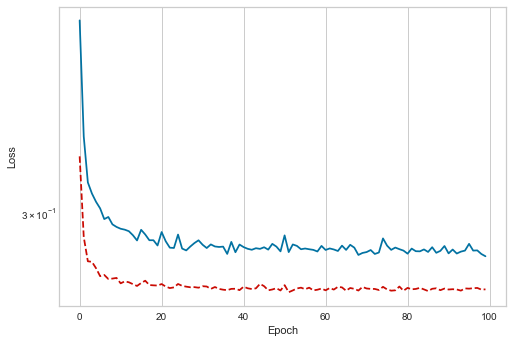

In [63]:
plot_loss(careful_bias_history,"Bias")

In [64]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_feats,
    y_train,
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(val_feats, y_val))

Epoch 1/100
111/111 [==============================] - 2s 7ms/step - loss: 0.3478 - tp: 44.0000 - fp: 23.0000 - tn: 30739.0000 - fn: 3583.0000 - accuracy: 0.8951 - precision: 0.6567 - recall: 0.0121 - auc: 0.5918 - prc: 0.1773 - val_loss: 0.3126 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5420.0000 - val_fn: 633.0000 - val_accuracy: 0.8954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7264 - val_prc: 0.2669
Epoch 2/100
111/111 [==============================] - 0s 1ms/step - loss: 0.3157 - tp: 90.0000 - fp: 77.0000 - tn: 25265.0000 - fn: 2904.0000 - accuracy: 0.8948 - precision: 0.5389 - recall: 0.0301 - auc: 0.6661 - prc: 0.2306 - val_loss: 0.2949 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5420.0000 - val_fn: 633.0000 - val_accuracy: 0.8954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7633 - val_prc: 0.3370
Epoch 3/100
111/111 [==============================] - 0s 1ms/step - loss: 0.3083 - tp: 159.0000 - fp: 122.0000 - tn: 2522

111/111 [==============================] - 0s 1ms/step - loss: 0.2948 - tp: 185.0000 - fp: 144.0000 - tn: 25198.0000 - fn: 2809.0000 - accuracy: 0.8958 - precision: 0.5623 - recall: 0.0618 - auc: 0.7618 - prc: 0.3054 - val_loss: 0.2843 - val_tp: 35.0000 - val_fp: 12.0000 - val_tn: 5408.0000 - val_fn: 598.0000 - val_accuracy: 0.8992 - val_precision: 0.7447 - val_recall: 0.0553 - val_auc: 0.7754 - val_prc: 0.3473
Epoch 21/100
111/111 [==============================] - 0s 1ms/step - loss: 0.2941 - tp: 205.0000 - fp: 148.0000 - tn: 25194.0000 - fn: 2789.0000 - accuracy: 0.8964 - precision: 0.5807 - recall: 0.0685 - auc: 0.7651 - prc: 0.3101 - val_loss: 0.2842 - val_tp: 37.0000 - val_fp: 12.0000 - val_tn: 5408.0000 - val_fn: 596.0000 - val_accuracy: 0.8996 - val_precision: 0.7551 - val_recall: 0.0585 - val_auc: 0.7754 - val_prc: 0.3467
Epoch 22/100
111/111 [==============================] - 0s 1ms/step - loss: 0.2942 - tp: 207.0000 - fp: 138.0000 - tn: 25204.0000 - fn: 2787.0000 - accuracy:

111/111 [==============================] - 0s 1ms/step - loss: 0.2929 - tp: 194.0000 - fp: 142.0000 - tn: 25200.0000 - fn: 2800.0000 - accuracy: 0.8962 - precision: 0.5774 - recall: 0.0648 - auc: 0.7658 - prc: 0.3097 - val_loss: 0.2839 - val_tp: 34.0000 - val_fp: 12.0000 - val_tn: 5408.0000 - val_fn: 599.0000 - val_accuracy: 0.8991 - val_precision: 0.7391 - val_recall: 0.0537 - val_auc: 0.7764 - val_prc: 0.3488
Epoch 40/100
111/111 [==============================] - 0s 1ms/step - loss: 0.2940 - tp: 181.0000 - fp: 140.0000 - tn: 25202.0000 - fn: 2813.0000 - accuracy: 0.8958 - precision: 0.5639 - recall: 0.0605 - auc: 0.7649 - prc: 0.3088 - val_loss: 0.2840 - val_tp: 32.0000 - val_fp: 12.0000 - val_tn: 5408.0000 - val_fn: 601.0000 - val_accuracy: 0.8987 - val_precision: 0.7273 - val_recall: 0.0506 - val_auc: 0.7759 - val_prc: 0.3489
Epoch 41/100
111/111 [==============================] - 0s 1ms/step - loss: 0.2920 - tp: 199.0000 - fp: 123.0000 - tn: 25219.0000 - fn: 2795.0000 - accuracy:

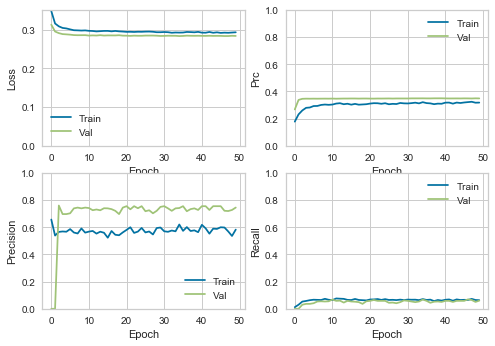

In [65]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
plot_metrics(baseline_history)

In [66]:
train_predictions_baseline = model.predict(train_feats)
test_predictions_baseline = model.predict(test_feats)


test_preds = []
test_probs = []
for i in test_predictions_baseline:
    if i > 0.5:
        test_preds.append(1)
        test_probs.append(i)
    
    else:
        test_preds.append(0)
        test_probs.append(i)


TP = sum([(p and l) for (p,l) in zip(test_preds, y_test)])
FP = sum([(p and not l) for (p,l) in zip(test_preds, y_test)])
TN = sum([(not p and not l) for (p,l) in zip(test_preds, y_test)])
FN = sum([(not p and l) for (p,l) in zip(test_preds, y_test)])
    
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
    
BER = 1 - .5 * (TPR + TNR)
    
precision = TP/(TP+FP)
recall = TP/(TP + FN)
    
F1 = 2 * (precision*recall)/(precision + recall)

accuracy = (TP + TN)/(TP + FP + TN + FN)

print(BER)
print(precision)
print(recall)
print(F1)
print(accuracy)

0.47644560208375075
0.6956521739130435
0.049689440993788817
0.0927536231884058
0.8968528587905751


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
0.13589972838556263
Coeffs
[1.2598629]
0.08196255281919701
0.13589972838556263


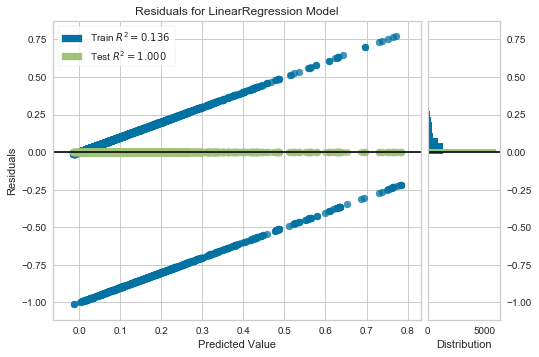

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot




Y = []
X = []
count1 = 0
count2 = 0
for i in range(len(test_probs)):
    count1 += test_probs[i]
    count2 += y_test[i]
    
    
    X.append(count1)
    Y.append(count2)
    count1 = 0
    count2 = 0

print(Y[0:10])
X = np.array(X)
X = X.reshape(-1,1)



lin = LinearRegression().fit(X,Y)

print(lin.score(X,Y))

lpreds = lin.predict(X)
print('Coeffs')
print(lin.coef_)

print(mean_squared_error(Y,lpreds))
print(r2_score(Y,lpreds))


visualizer = ResidualsPlot(lin)
visualizer.fit(X,Y)
visualizer.score(X,lpreds)
visualizer.show()

In [68]:
"""Model learns to just pick zero since classes are so imbalanced"""


'Model learns to just pick zero since classes are so imbalanced'

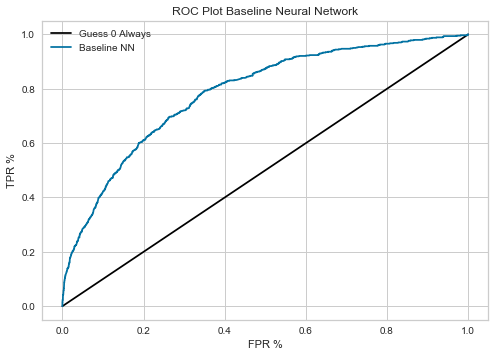

0.7847708732862009


In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

r_probs = [0 for _ in range(len(y_test))]

r_auc = roc_auc_score(y_test,r_probs)
nn_auc = roc_auc_score(y_test,test_probs)

r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)
nn_fpr,nn_tpr,_ = roc_curve(y_test,test_probs)



plt.plot(r_fpr,r_tpr, label = 'Guess 0 Always',color='black')
plt.plot(nn_fpr,nn_tpr, label = 'Baseline NN',color ='b')

plt.title('ROC Plot Baseline Neural Network')
plt.xlabel('FPR %')
plt.ylabel('TPR %')
plt.legend()
plt.show()

print(nn_auc)

In [70]:
"""Fix Class Imbalance"""

'Fix Class Imbalance'

In [71]:
weight_0 = (1/negative) * (positive+negative/2.0)
weight_1 = (1/positive) * (positive+negative/2.0)

class_weight = {0: weight_0, 1: weight_1}

print(weight_0)
print(weight_1)

0.6180258103738911
5.236361507843596


In [72]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_feats,
    y_train,
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(val_feats, y_val),
    class_weight=class_weight)

Epoch 1/100
111/111 [==============================] - 2s 7ms/step - loss: 1.2228 - tp: 189.0000 - fp: 506.0000 - tn: 30256.0000 - fn: 3438.0000 - accuracy: 0.8853 - precision: 0.2719 - recall: 0.0521 - auc: 0.5595 - prc: 0.1454 - val_loss: 0.3606 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 5417.0000 - val_fn: 626.0000 - val_accuracy: 0.8961 - val_precision: 0.7000 - val_recall: 0.0111 - val_auc: 0.7128 - val_prc: 0.2532
Epoch 2/100
111/111 [==============================] - 0s 2ms/step - loss: 0.8734 - tp: 1074.0000 - fp: 4345.0000 - tn: 20997.0000 - fn: 1920.0000 - accuracy: 0.7789 - precision: 0.1982 - recall: 0.3587 - auc: 0.6086 - prc: 0.2091 - val_loss: 0.4416 - val_tp: 235.0000 - val_fp: 453.0000 - val_tn: 4967.0000 - val_fn: 398.0000 - val_accuracy: 0.8594 - val_precision: 0.3416 - val_recall: 0.3712 - val_auc: 0.7654 - val_prc: 0.3378
Epoch 3/100
111/111 [==============================] - 0s 2ms/step - loss: 0.7980 - tp: 1299.0000 - fp: 5176.0000 - tn: 20166.0000 - fn: 1695.00

Epoch 20/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6622 - tp: 1700.0000 - fp: 5537.0000 - tn: 19805.0000 - fn: 1294.0000 - accuracy: 0.7589 - precision: 0.2349 - recall: 0.5678 - auc: 0.7551 - prc: 0.2947 - val_loss: 0.5412 - val_tp: 409.0000 - val_fp: 1326.0000 - val_tn: 4094.0000 - val_fn: 224.0000 - val_accuracy: 0.7439 - val_precision: 0.2357 - val_recall: 0.6461 - val_auc: 0.7760 - val_prc: 0.3471
Epoch 21/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6638 - tp: 1763.0000 - fp: 5747.0000 - tn: 19595.0000 - fn: 1231.0000 - accuracy: 0.7537 - precision: 0.2348 - recall: 0.5888 - auc: 0.7532 - prc: 0.2890 - val_loss: 0.5427 - val_tp: 410.0000 - val_fp: 1346.0000 - val_tn: 4074.0000 - val_fn: 223.0000 - val_accuracy: 0.7408 - val_precision: 0.2335 - val_recall: 0.6477 - val_auc: 0.7762 - val_prc: 0.3485
Epoch 22/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6594 - tp: 1778.0000 - fp: 5717.0000 - tn: 19625.0000 - 

Epoch 39/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6481 - tp: 1856.0000 - fp: 6113.0000 - tn: 19229.0000 - fn: 1138.0000 - accuracy: 0.7441 - precision: 0.2329 - recall: 0.6199 - auc: 0.7622 - prc: 0.3111 - val_loss: 0.5570 - val_tp: 421.0000 - val_fp: 1485.0000 - val_tn: 3935.0000 - val_fn: 212.0000 - val_accuracy: 0.7196 - val_precision: 0.2209 - val_recall: 0.6651 - val_auc: 0.7750 - val_prc: 0.3498
Epoch 40/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6485 - tp: 1886.0000 - fp: 6092.0000 - tn: 19250.0000 - fn: 1108.0000 - accuracy: 0.7459 - precision: 0.2364 - recall: 0.6299 - auc: 0.7632 - prc: 0.3063 - val_loss: 0.5651 - val_tp: 433.0000 - val_fp: 1517.0000 - val_tn: 3903.0000 - val_fn: 200.0000 - val_accuracy: 0.7163 - val_precision: 0.2221 - val_recall: 0.6840 - val_auc: 0.7752 - val_prc: 0.3514
Epoch 41/100
111/111 [==============================] - 0s 2ms/step - loss: 0.6487 - tp: 1857.0000 - fp: 6015.0000 - tn: 19327.0000 - 

In [73]:
train_preds_weighted = weighted_model.predict(train_feats)
test_preds_weighted = weighted_model.predict(test_feats)


test_predictions_weighted = []
test_probs_weighted = []

for i in test_preds_weighted:
    if i > 0.5:
        test_predictions_weighted.append(1)
        test_probs_weighted.append(i)
    
    else:
        test_predictions_weighted.append(0)
        test_probs_weighted.append(i)
        


TP = sum([(p and l) for (p,l) in zip(test_predictions_weighted, y_test)])
FP = sum([(p and not l) for (p,l) in zip(test_predictions_weighted, y_test)])
TN = sum([(not p and not l) for (p,l) in zip(test_predictions_weighted, y_test)])
FN = sum([(not p and l) for (p,l) in zip(test_predictions_weighted, y_test)])
    
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
    
BER = 1 - .5 * (TPR + TNR)
    
precision = TP/(TP+FP)
recall = TP/(TP + FN)
    
F1 = 2 * (precision*recall)/(precision + recall)

accuracy = (TP + TN)/(TP + FP + TN + FN)

print("Balanced Error rate: " + str(BER))
print("Precision: " + str(precision))
print('Recall: ' + str(recall))
print('F1 score: ' + str(F1))
print('Total Classification Accuracy: ' + str(accuracy))

Balanced Error rate: 0.28488178721699065
Precision: 0.23410852713178296
Recall: 0.703416149068323
F1 score: 0.3512989530825902
Total Classification Accuracy: 0.7243367935409458


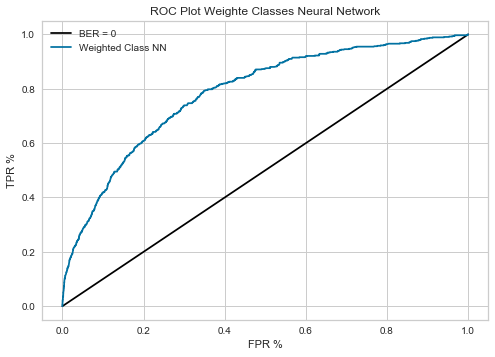

0.7843680052666228


In [74]:
r_probs = [0 for _ in range(len(y_test))]

r_auc = roc_auc_score(y_test,r_probs)
nn_auc = roc_auc_score(y_test,test_probs_weighted)

r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)
nn_fpr,nn_tpr,_ = roc_curve(y_test,test_probs_weighted)



plt.plot(r_fpr,r_tpr, label = 'BER = 0',color='black')
plt.plot(nn_fpr,nn_tpr, label = 'Weighted Class NN',color='b')

plt.title('ROC Plot Weighte Classes Neural Network')
plt.xlabel('FPR %')
plt.ylabel('TPR %')
plt.legend()
plt.show()

print(nn_auc)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
0.11843761348068904
Coeffs
[0.5461284]
0.08361888780975492
0.11843761348068904


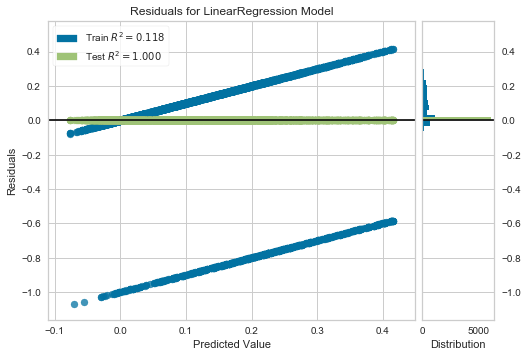

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot




Y = []
X = []
count1 = 0
count2 = 0
for i in range(len(test_probs_weighted)):
    count1 += test_probs_weighted[i]
    count2 += y_test[i]
    
    
    X.append(count1)
    Y.append(count2)
    count1 = 0
    count2 = 0

print(Y[0:10])
X = np.array(X)
X = X.reshape(-1,1)



lin = LinearRegression().fit(X,Y)

print(lin.score(X,Y))

lpreds = lin.predict(X)
print('Coeffs')
print(lin.coef_)

print(mean_squared_error(Y,lpreds))
print(r2_score(Y,lpreds))


visualizer = ResidualsPlot(lin)
visualizer.fit(X,Y)
visualizer.score(X,lpreds)
visualizer.show()